Lightly edited for clarity as Noah goes through this...

# Compartmental Models

In [ ]:
# Adapted from https://pyro.ai/examples/sir_hmc.html by Swapneel and Noah

In [1]:
import argparse
import logging
import math
import re
from collections import OrderedDict

import torch
from torch import distributions as tdist
from pyro import distributions as dist

from matplotlib import pyplot as plt
import seaborn as sns
import logging

import pyro.distributions as dist
import pyro.distributions.hmm
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, config_enumerate, infer_discrete
from pyro.infer.autoguide import init_to_value
from pyro.ops.special import safe_log
from pyro.ops.tensor_utils import convolve
from pyro.util import warn_if_nan
#plt.style.use('dark_background')

logging.basicConfig(format='%(message)s', level=logging.INFO)


Trying to run this. Memory gets used up. Will update as I go. 

### 1. The Priors we place on R0 and $\rho$

Text(0.5, 1.0, 'Prior on R0 (reproduction number)')

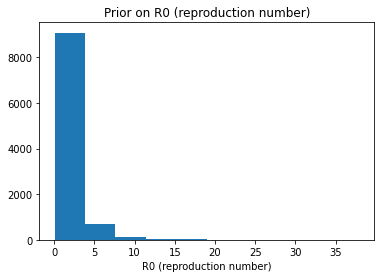

In [5]:
#fig, ax = plt.subplots(1, 2, figsize=(18, 6))

r0_dist = tdist.LogNormal(0., 1.) # we form a prior distribution on r0 that it's a lognormal dist. 
r0_samples = r0_dist.sample(torch.Size([10000]))

plt.hist(r0_samples.numpy()) # this is weird as f. Only goes fast if converted to numpy?
#sns.hist(r0_samples, ax=ax[0])
plt.xlabel('R0 (reproduction number)')
plt.title('Prior on R0 (reproduction number)')


(array([9.086e+03, 6.980e+02, 1.410e+02, 4.300e+01, 1.600e+01, 6.000e+00,
        6.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([3.0360447e-02, 3.8180337e+00, 7.6057072e+00, 1.1393380e+01,
        1.5181053e+01, 1.8968727e+01, 2.2756399e+01, 2.6544073e+01,
        3.0331747e+01, 3.4119419e+01, 3.7907093e+01], dtype=float32),
 <BarContainer object of 10 artists>)

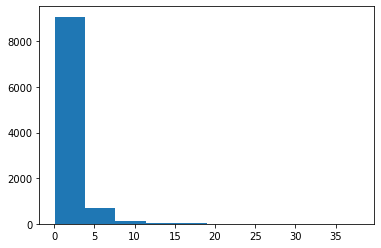

In [6]:
plt.hist(r0_samples.numpy())

In [35]:
def global_model(population):
    """
    From the population and initial values for recovery time, R0, and rho, convert interpretable values
    
    (an epidemiologist knows what R0 is but not rate_s), into the parameters needed for the distribution. 
    
    
    Returns
    -------
    
    rate_s: rate of infection i 
    
    prob_i: probality of infection? 
    
    rho: not sure yet. 
    """
    tau = args.recovery_time  # Assume this can be measured exactly... TODO: Why not make this also a dist? 
    R0 = pyro.sample("R0", dist.LogNormal(0., 1.)) #these models are priors on what we considered args. 
    rho = pyro.sample("rho", dist.Uniform(0, 1))

    # Convert interpretable parameters to distribution parameters.
    rate_s = -R0 / (tau * population)
    prob_i = 1 / (1 + tau)

    return rate_s, prob_i, rho


def discrete_model(args, data):
    """
    create discrete model 
    
    This enumerates through the data, and computes what the actual S and I (and therefore R) values R at each timestep, 
    and saves in a messy dictionary under poutine. 
    
    This messy info is then saved in a more ordered format through 
    """
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population) # global parameters are what the current estimates are. 

    # Sequentially sample time-local variables.
    S = torch.tensor(args.population - 1.)
    I = torch.tensor(1.)
    for t, datum in enumerate(data): # for data point in dataset, use this distribution to  
        S2I = pyro.sample("S2I_{}".format(t),
                          dist.Binomial(S, -(rate_s * I).expm1())) # the actual formula 
        I2R = pyro.sample("I2R_{}".format(t),
                          dist.Binomial(I, prob_i))
        S = pyro.deterministic("S_{}".format(t), S - S2I) 
        I = pyro.deterministic("I_{}".format(t), I + S2I - I2R) # the diff eqs 
        pyro.sample("obs_{}".format(t),
                    dist.ExtendedBinomial(S2I, rho),
                    obs=datum)
        


In [36]:

logging.info("Generating data...")
params = {"R0": torch.tensor(args.basic_reproduction_number), #what we set 
          "rho": torch.tensor(args.response_rate)}
empty_data = [None] * (args.duration + args.forecast)
for attempt in range(100):
    with poutine.trace() as tr:
        with poutine.condition(data=params):
            discrete_model(args, empty_data)

Generating data...


In [39]:
tr.trace.nodes.items()

odict_items([('R0', {'type': 'sample', 'name': 'R0', 'fn': LogNormal(), 'is_observed': True, 'args': (), 'kwargs': {}, 'value': tensor(0.5000), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}), ('rho', {'type': 'sample', 'name': 'rho', 'fn': Uniform(low: 0.0, high: 1.0), 'is_observed': True, 'args': (), 'kwargs': {}, 'value': tensor(0.5000), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}), ('S2I_0', {'type': 'sample', 'name': 'S2I_0', 'fn': Binomial(total_count: 99.0, probs: 0.0007140306406654418, logits: -7.243870258331299), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}), ('I2R_0', {'type': 'sample', 'name': 'I2R_0', 'fn': Binomial(total_count: 1.0, probs: 0.125, logits: -1.9459102153778076), 'is_observed': False,

In [8]:
# We can use this model to simulate data. We'll use poutine.condition to pin
# parameter values and poutine.trace to record sample observations.

def generate_data(args):
    """
    Simulate data. 
    
    Using args to input initial estimates on R0 and other epidemiology jargon, return a list of the compartment populations
    according to these conditions. 
    
    S2I, I2R
    """
    logging.info("Generating data...")
    params = {"R0": torch.tensor(args.basic_reproduction_number), #what we set 
              "rho": torch.tensor(args.response_rate)}
    empty_data = [None] * (args.duration + args.forecast)

    # We'll retry until we get an actual outbreak.
    for attempt in range(100):
        with poutine.trace() as tr:
            with poutine.condition(data=params):
                discrete_model(args, empty_data)

        # Concatenate sequential time series into tensors.
        obs = torch.stack([site["value"]
                           for name, site in tr.trace.nodes.items()
                           if re.match("obs_[0-9]+", name)])
        S2I = torch.stack([site["value"]
                          for name, site in tr.trace.nodes.items()
                          if re.match("S2I_[0-9]+", name)])
    
        I2R = torch.stack([site["value"]
                          for name, site in tr.trace.nodes.items()
                          if re.match("I2R_[0-9]+", name)])
        
        
        
        assert len(obs) == len(empty_data)

        obs_sum = int(obs[:args.duration].sum())
        S2I_sum = int(S2I[:args.duration].sum())
        I2R_sum = int(I2R[:args.duration].sum())
        if obs_sum >= args.min_observations:
            logging.info("Observed {:d}/{:d} infections:\n{}".format(
                obs_sum, S2I_sum, I2R_sum, " ".join([str(int(x)) for x in obs[:args.duration]])))
            return {"S2I": S2I, "obs": obs, "I2R": I2R}

    raise ValueError("Failed to generate {} observations. Try increasing "
                     "--population or decreasing --min-observations"
                     .format(args.min_observations))



In [9]:
from argparse import Namespace
args = Namespace(population=100, 
                 min_observations=3, 
                 duration=17, 
                 forecast=0, 
                 basic_reproduction_number=.5,  # what our epidemic's R0 is.
                 recovery_time=7.0,  #recovery timne. These values are 
                 response_rate=0.5, 
                 enum=True, 
                 sequential=True, 
                 num_samples=2000, 
                 warmup_steps=100, 
                 max_tree_depth=5, 
                 rng_seed=0, 
                 double=True, 
                 jit=True, 
                 cuda=True, 
                 verbose=True, 
                 plot=True)

In [10]:
x = generate_data(args)
x

Generating data...
Observed 4/5 infections:
4


{'S2I': tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'obs': tensor([1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'I2R': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.])}

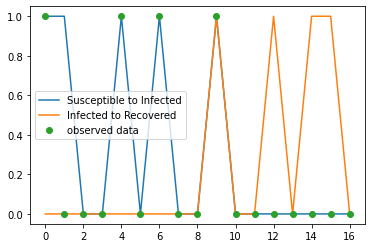

In [11]:
plt.plot(x['S2I'],label='Susceptible to Infected')
plt.plot(x['I2R'],label='Infected to Recovered')
plt.plot(x['obs'],'o',label='observed data')
plt.legend()

In [43]:
# Inference
# =========
#
# While the above discrete_model is easy to understand, its discrete latent
# variables pose a challenge for inference. One of the most popular inference
# strategies for such models is Sequential Monte Carlo. However since Pyro and
# PyTorch are stronger in gradient based vectorizable inference algorithms, we
# will instead pursue inference based on Hamiltonian Monte Carlo (HMC).
#
# Our general inference strategy will be to:
# 1. Introduce auxiliary variables to make the model Markov.
# 2. Introduce more auxiliary variables to create a discrete parameterization.
# 3. Marginalize out all remaining discrete latent variables.
# 4. Vectorize to enable parallel-scan temporal filtering.
#
# Let's consider reparameterizing in terms of the variables (S, I) rather than
# (S2I, I2R). Since these may lead to inconsistent states, we need to replace
# the Binomial transition factors (S2I, I2R) with ExtendedBinomial.
#
# The following model is equivalent to the discrete_model:

@config_enumerate
def reparameterized_discrete_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population) # again, these must be guesses? They have to change somehow.. 

    # Sequentially sample time-local variables.
    S_curr = torch.tensor(args.population - 1.)
    I_curr = torch.tensor(1.)
    for t, datum in enumerate(data):
        # Sample reparameterizing variables.
        # When reparameterizing to a factor graph, we ignored density via
        # .mask(False). Thus distributions are used only for initialization.
        S_prev, I_prev = S_curr, I_curr
        S_curr = pyro.sample("S_{}".format(t),
                             dist.Binomial(args.population, 0.5).mask(False))
        I_curr = pyro.sample("I_{}".format(t),
                             dist.Binomial(args.population, 0.5).mask(False))

        # Now we reverse the computation.
        S2I = S_prev - S_curr
        I2R = I_prev - I_curr + S2I
        pyro.sample("S2I_{}".format(t),
                    dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()),
                    obs=S2I)
        pyro.sample("I2R_{}".format(t),
                    dist.ExtendedBinomial(I_prev, prob_i),
                    obs=I2R)
   #     pyro.sample("obs_{}".format(t),
              #      dist.ExtendedBinomial(S2I, rho),
                #    obs=datum)



In [44]:

# By reparameterizing, we have converted to coordinates that make the model
# Markov. We have also replaced dynamic integer_interval constraints with
# easier static integer_interval constraints (although we'll still need good
# initialization to avoid NANs). Since the discrete latent variables are
# bounded (by population size), we can enumerate out discrete latent variables
# and perform HMC inference over the global latents. However enumeration
# complexity is O(population^4), so this is only feasible for very small
# populations.
#
# Here is an inference approach using an MCMC sampler.




def _infer_hmc(args, data, model, init_values={}):
    """
    Run Hamiltonian Monte Carlo mcmc to estimate parameters R0 and rho
    """
    logging.info("Running inference...")
    kernel = NUTS(model,
                  full_mass=[("R0", "rho")],
                  max_tree_depth=args.8,
                  init_strategy=init_to_value(values=init_values),
                  jit_compile=args.jit, ignore_jit_warnings=True)

    # We'll define a hook_fn to log potential energy values during inference.
    # This is helpful to diagnose whether the chain is mixing.
    energies = []

    def hook_fn(kernel, *unused):
        e = float(kernel._potential_energy_last)
        energies.append(e)
        if args.verbose:
            logging.info("potential = {:0.6g}".format(e))

    mcmc = MCMC(kernel, hook_fn=hook_fn,
                num_samples=args.num_samples,
                warmup_steps=args.warmup_steps)
    mcmc.run(args, data)
    mcmc.summary()
    if args.plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 3))
        plt.plot(energies)
        plt.xlabel("MCMC step")
        plt.ylabel("potential energy")
        plt.title("MCMC energy trace")
        plt.tight_layout()

    samples = mcmc.get_samples()
    return samples

def infer_hmc_enum(args, data):
    model = reparameterized_discrete_model
    return _infer_hmc(args, data, model)


SyntaxError: invalid syntax (<ipython-input-44-df628f1002e9>, line 22)

In [14]:
# To scale to large populations, we'll continue to reparameterize, this time
# replacing each of (S_aux,I_aux) with a combination of a bounded real
# variable and a Categorical variable with only four values.
#
# This is the crux: we can now perform HMC over the real variable and
# marginalize out the Categorical variables using variable elimination.
#
# We first define a helper to create enumerated Categorical sites.

def quantize(name, x_real, min, max):
    """
    Randomly quantize in a way that preserves probability mass.
    We use a piecewise polynomial spline of order 3.
    """
    assert min < max
    lb = x_real.detach().floor()

    # This cubic spline interpolates over the nearest four integers, ensuring
    # piecewise quadratic gradients.
    s = x_real - lb
    ss = s * s
    t = 1 - s
    tt = t * t
    probs = torch.stack([
        t * tt,
        4 + ss * (3 * s - 6),
        4 + tt * (3 * t - 6),
        s * ss,
    ], dim=-1) * (1/6)
    q = pyro.sample("Q_" + name, dist.Categorical(probs)).type_as(x_real)

    x = lb + q - 1
    x = torch.max(x, 2 * min - 1 - x)
    x = torch.min(x, 2 * max + 1 - x)

    return pyro.deterministic(name, x)


In [15]:
# Now we can define another equivalent model.

@config_enumerate
def continuous_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sample reparameterizing variables.
    S_aux = pyro.sample("S_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))
    I_aux = pyro.sample("I_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))

    # Sequentially sample time-local variables.
    S_curr = torch.tensor(args.population - 1.)
    I_curr = torch.tensor(1.)
    for t, datum in poutine.markov(enumerate(data)):
        S_prev, I_prev = S_curr, I_curr
        S_curr = quantize("S_{}".format(t), S_aux[..., t], min=0, max=args.population)
        I_curr = quantize("I_{}".format(t), I_aux[..., t], min=0, max=args.population)

        # Now we reverse the computation.
        S2I = S_prev - S_curr
        I2R = I_prev - I_curr + S2I
        pyro.sample("S2I_{}".format(t),
                    dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()),
                    obs=S2I)
        pyro.sample("I2R_{}".format(t),
                    dist.ExtendedBinomial(I_prev, prob_i),
                    obs=I2R)
        pyro.sample("obs_{}".format(t),
                    dist.ExtendedBinomial(S2I, rho),
                    obs=datum)

In [16]:

# Now all latent variables in the continuous_model are either continuous or
# enumerated, so we can use HMC. However we need to take special care with
# constraints because the above Markov reparameterization covers regions of
# hypothesis space that are infeasible (i.e. whose log_prob is -infinity). We
# thus heuristically initialize to a feasible point.

def heuristic_init(args, data):
    """Heuristically initialize to a feasible point."""
    # Start with a single infection.
    S0 = args.population - 1
    # Assume 50% <= response rate <= 100%.
    S2I = data * min(2., (S0 / data.sum()).sqrt())
    S_aux = (S0 - S2I.cumsum(-1)).clamp(min=0.5) # clamp 
    # Account for the single initial infection.
    S2I[0] += 1
    # Assume infection lasts less than a month.
    recovery = torch.arange(30.).div(args.recovery_time).neg().exp()
    I_aux = convolve(S2I, recovery)[:len(data)].clamp(min=0.5)

    return {
        "R0": torch.tensor(2.0),
        "rho": torch.tensor(0.5),
        "S_aux": S_aux,
        "I_aux": I_aux,
    }


def infer_hmc_cont(model, args, data):
    init_values = heuristic_init(args, data)
    return _infer_hmc(args, data, model, init_values=init_values)


# Our final inference trick is to vectorize. We can repurpose DiscreteHMM's
# implementation here, but we'll need to manually represent a Markov
# neighborhood of multiple Categorical of size 4 as single joint Categorical
# with 4 * 4 = 16 states, and then manually perform variable elimination (the
# factors here don't quite conform to DiscreteHMM's interface).

def quantize_enumerate(x_real, min, max):
    """
    Randomly quantize in a way that preserves probability mass.
    We use a piecewise polynomial spline of order 3.
    """
    assert min < max
    lb = x_real.detach().floor()

    # This cubic spline interpolates over the nearest four integers, ensuring
    # piecewise quadratic gradients.
    s = x_real - lb
    ss = s * s
    t = 1 - s
    tt = t * t
    probs = torch.stack([
        t * tt,
        4 + ss * (3 * s - 6),
        4 + tt * (3 * t - 6),
        s * ss,
    ], dim=-1) * (1/6)
    logits = safe_log(probs)
    q = torch.arange(-1., 3.)

    x = lb.unsqueeze(-1) + q
    x = torch.max(x, 2 * min - 1 - x)
    x = torch.min(x, 2 * max + 1 - x)
    return x, logits


def vectorized_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sample reparameterizing variables.
    S_aux = pyro.sample("S_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))
    I_aux = pyro.sample("I_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))

    # Manually enumerate.
    S_curr, S_logp = quantize_enumerate(S_aux, min=0, max=args.population)
    I_curr, I_logp = quantize_enumerate(I_aux, min=0, max=args.population)
    # Truncate final value from the right then pad initial value onto the left.
    S_prev = torch.nn.functional.pad(S_curr[:-1], (0, 0, 1, 0), value=args.population - 1)
    I_prev = torch.nn.functional.pad(I_curr[:-1], (0, 0, 1, 0), value=1)
    # Reshape to support broadcasting, similar to EnumMessenger.
    T = len(data)
    Q = 4
    S_prev = S_prev.reshape(T, Q, 1, 1, 1)
    I_prev = I_prev.reshape(T, 1, Q, 1, 1)
    S_curr = S_curr.reshape(T, 1, 1, Q, 1)
    S_logp = S_logp.reshape(T, 1, 1, Q, 1)
    I_curr = I_curr.reshape(T, 1, 1, 1, Q)
    I_logp = I_logp.reshape(T, 1, 1, 1, Q)
    data = data.reshape(T, 1, 1, 1, 1)

    # Reverse the S2I,I2R computation.
    S2I = S_prev - S_curr
    I2R = I_prev - I_curr + S2I

    # Compute probability factors.
    S2I_logp = dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()).log_prob(S2I)
    I2R_logp = dist.ExtendedBinomial(I_prev, prob_i).log_prob(I2R)
    obs_logp = dist.ExtendedBinomial(S2I, rho).log_prob(data)

    # Manually perform variable elimination.
    logp = S_logp + (I_logp + obs_logp) + S2I_logp + I2R_logp
    logp = logp.reshape(-1, Q * Q, Q * Q)
    logp = pyro.distributions.hmm._sequential_logmatmulexp(logp)
    logp = logp.reshape(-1).logsumexp(0)
    logp = logp - math.log(4)  # Account for S,I initial distributions.
    warn_if_nan(logp)
    pyro.factor("obs", logp)


# We can fit vectorized_model exactly as we fit the original continuous_model,
# using our infer_hmc_cont helper. The vectorized model is more than an order
# of magnitude faster than the sequential version, and scales logarithmically
# in time (up to your machine's parallelism).
#
# After inference we have samples of all latent variables. Let's define a
# helper to examine the inferred posterior distributions.

def evaluate(args, samples):
    # Print estimated values.
    names = {"basic_reproduction_number": "R0",
             "response_rate": "rho"}
    for name, key in names.items():
        mean = samples[key].mean().item()
        std = samples[key].std().item()
        logging.info("{}: truth = {:0.3g}, estimate = {:0.3g} \u00B1 {:0.3g}"
                     .format(key, getattr(args, name), mean, std))

    # Optionally plot histograms.
    if args.plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        fig, axes = plt.subplots(2, 1, figsize=(5, 5))
        axes[0].set_title("Posterior parameter estimates")
        for ax, (name, key) in zip(axes, names.items()):
            truth = getattr(args, name)
            sns.distplot(samples[key], ax=ax, label="posterior")
            ax.axvline(truth, color="k", label="truth")
            ax.set_xlabel(key + " = " + name.replace("_", " "))
            ax.set_yticks(())
            ax.legend(loc="best")
        plt.tight_layout()


In [17]:

# Prediction and Forecasting
# ==========================
#
# So far we've written four models that each describe the same probability
# distribution. Each successive model made inference cheaper. Next let's move
# beyond inference and consider predicting latent infection rate and
# forecasting future infections.
#
# We'll use Pyro's effect handlers to combine multiple of the above models,
# leveraging the vectorized_model for inference, then the continuous_model to
# compute local latent variables, and finally the original discrete_model to
# forecast forward in time. Let's assume posterior samples have already been
# generated via infer_hmc_cont(vectorized_model, ...).

@torch.no_grad()
def predict(args, data, samples, truth=None):
    logging.info("Forecasting {} steps ahead...".format(args.forecast))
    particle_plate = pyro.plate("particles", args.num_samples, dim=-1)

    # First we sample discrete auxiliary variables from the continuous
    # variables sampled in vectorized_model. This samples only time steps
    # [0:duration]. Here infer_discrete runs a forward-filter backward-sample
    # algorithm. We'll add these new samples to the existing dict of samples.
    model = poutine.condition(continuous_model, samples)
    model = particle_plate(model)
    model = infer_discrete(model, first_available_dim=-2)
    with poutine.trace() as tr:
        model(args, data)
    samples = OrderedDict((name, site["value"])
                          for name, site in tr.trace.nodes.items()
                          if site["type"] == "sample")

    # Next we'll run the forward generative process in discrete_model. This
    # samples time steps [duration:duration+forecast]. Again we'll update the
    # dict of samples.
    extended_data = list(data) + [None] * args.forecast
    model = poutine.condition(discrete_model, samples)
    model = particle_plate(model)
    with poutine.trace() as tr:
        model(args, extended_data)
    samples = OrderedDict((name, site["value"])
                          for name, site in tr.trace.nodes.items()
                          if site["type"] == "sample")

    # Finally we'll concatenate the sequentially sampled values into contiguous
    # tensors. This operates on the entire time interval [0:duration+forecast].
    for key in ("S", "I", "S2I", "I2R"):
        pattern = key + "_[0-9]+"
        series = [value
                  for name, value in samples.items()
                  if re.match(pattern, name)]
        assert len(series) == args.duration + args.forecast
        series[0] = series[0].expand(series[1].shape)
        samples[key] = torch.stack(series, dim=-1)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    logging.info("Median prediction of new infections (starting on day 0):\n{}"
                 .format(" ".join(map(str, map(int, median)))))

    # Optionally plot the latent and forecasted series of new infections.
    if args.plot:
        import matplotlib.pyplot as plt
        plt.figure()
        time = torch.arange(args.duration + args.forecast)
        p05 = S2I.kthvalue(int(round(0.5 + 0.05 * args.num_samples)), dim=0).values
        p95 = S2I.kthvalue(int(round(0.5 + 0.95 * args.num_samples)), dim=0).values
        plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
        plt.plot(time, median, "r-", label="median")
        plt.plot(time[:args.duration], data, "k.", label="observed")
        if truth is not None:
            plt.plot(time, truth, "k--", label="truth")
        plt.axvline(args.duration - 0.5, color="gray", lw=1)
        plt.xlim(0, len(time) - 1)
        plt.ylim(0, None)
        plt.xlabel("day after first infection")
        plt.ylabel("new infections per day")
        plt.title("New infections in population of {}".format(args.population))
        plt.legend(loc="upper left")
        plt.tight_layout()

    return samples


In [25]:
from argparse import Namespace
args = Namespace(population=100, 
                 min_observations=3, 
                 duration=17, 
                 forecast=0, 
                 basic_reproduction_number=.5,  # what our epidemic's R0 is.
                 recovery_time=7.0,  #recovery timne. These values are 
                 response_rate=0.5, 
                 enum=False, 
                 sequential=False, 
                 num_samples=2000, 
                 warmup_steps=100, 
                 max_tree_depth=5, 
                 rng_seed=0, 
                 double=True, 
                 jit=True, 
                 cuda=True, 
                 verbose=True, 
                 plot=True)

Running inference...
Warmup:   0%|          | 1/2100 [00:01,  1.40s/it, step size=9.05e-01, acc. prob=0.622]potential = 17.5674
potential = 17.5674
Warmup:   1%|          | 22/2100 [00:08,  3.71it/s, step size=1.84e-01, acc. prob=0.770]potential = 19.4477
potential = 19.4477
Warmup:   2%|▏         | 36/2100 [00:13,  3.13it/s, step size=9.62e-02, acc. prob=0.773]potential = 23.4915
potential = 17.0702
Warmup:   2%|▏         | 40/2100 [00:14,  3.21it/s, step size=1.85e-01, acc. prob=0.781]potential = 16.505
potential = 21.633
Warmup:   2%|▏         | 48/2100 [00:16,  4.62it/s, step size=1.27e-01, acc. prob=0.780]potential = 18.5191
potential = 22.4025
Warmup:   3%|▎         | 54/2100 [00:17,  4.83it/s, step size=1.49e-01, acc. prob=0.783]potential = 25.0891
potential = 29.545
Warmup:   4%|▎         | 74/2100 [00:23,  4.04it/s, step size=1.19e-01, acc. prob=0.784]potential = 28.3761
potential = 28.3761
Warmup:   4%|▍         | 89/2100 [00:27,  2.56it/s, step size=4.61e-01, acc. prob=0.778

Sample:   9%|▉         | 189/2100 [00:58,  2.89it/s, step size=1.82e-01, acc. prob=0.750]potential = 20.6899
potential = 15.7082
Sample:   9%|▉         | 192/2100 [00:59,  3.57it/s, step size=1.82e-01, acc. prob=0.742]potential = 16.4289
potential = 20.0697
Sample:  11%|█         | 235/2100 [01:13,  2.77it/s, step size=1.82e-01, acc. prob=0.757]potential = 15.4115


Sample:  12%|█▏        | 255/2100 [01:19,  3.43it/s, step size=1.82e-01, acc. prob=0.772]potential = 20.3261
potential = 25.977
Sample:  13%|█▎        | 283/2100 [01:29,  2.71it/s, step size=1.82e-01, acc. prob=0.778]potential = 26.1509
potential = 22.3915
Sample:  15%|█▍        | 312/2100 [01:37,  2.97it/s, step size=1.82e-01, acc. prob=0.769]potential = 14.0412


Sample:  15%|█▌        | 319/2100 [01:40,  2.52it/s, step size=1.82e-01, acc. prob=0.769]potential = 14.793
potential = 19.0642
Sample:  16%|█▌        | 331/2100 [01:43,  3.62it/s, step size=1.82e-01, acc. prob=0.758]potential = 14.5115
potential = 14.5115
Sample:  17%|█▋        | 363/2100 [01:53,  3.03it/s, step size=1.82e-01, acc. prob=0.765]potential = 20.6672
potential = 21.9704
Sample:  19%|█▉        | 405/2100 [02:07,  3.37it/s, step size=1.82e-01, acc. prob=0.768]potential = 10.478
potential = 1.76118
Sample:  21%|██        | 433/2100 [02:15,  2.65it/s, step size=1.82e-01, acc. prob=0.758]potential = -8.18066
potential = 0.791592
Sample:  21%|██        | 444/2100 [02:19,  2.71it/s, step size=1.82e-01, acc. prob=0.747]potential = -0.0208969
potential = -0.0208969
potential = -0.0208969
Sample:  22%|██▏       | 467/2100 [02:26,  3.69it/s, step size=1.82e-01, acc. prob=0.735]potential = 15.7427


Sample:  27%|██▋       | 557/2100 [02:51,  3.89it/s, step size=1.82e-01, acc. prob=0.737]potential = 15.6305
potential = 15.6305
potential = 12.5145
Sample:  29%|██▉       | 619/2100 [03:08,  3.37it/s, step size=1.82e-01, acc. prob=0.739]potential = 6.45401


Sample:  31%|███▏      | 657/2100 [03:21,  3.00it/s, step size=1.82e-01, acc. prob=0.722]potential = 3.48877
potential = 0.804728
Sample:  32%|███▏      | 678/2100 [03:27,  3.37it/s, step size=1.82e-01, acc. prob=0.717]potential = 0.485798
potential = -2.23294
Sample:  33%|███▎      | 685/2100 [03:29,  3.31it/s, step size=1.82e-01, acc. prob=0.714]potential = 1.07288
potential = 1.07288
Sample:  33%|███▎      | 694/2100 [03:32,  3.16it/s, step size=1.82e-01, acc. prob=0.707]potential = -6.36782
potential = -7.27956
Sample:  33%|███▎      | 696/2100 [03:32,  3.94it/s, step size=1.82e-01, acc. prob=0.706]potential = -7.27956
potential = -7.27956
Sample:  33%|███▎      | 698/2100 [03:32,  4.81it/s, step size=1.82e-01, acc. prob=0.704]potential = -1.73534


Sample:  34%|███▍      | 711/2100 [03:36,  2.88it/s, step size=1.82e-01, acc. prob=0.699]potential = -3.67877
potential = -3.67877
Sample:  34%|███▍      | 717/2100 [03:37,  3.24it/s, step size=1.82e-01, acc. prob=0.696]potential = 1.26906
potential = 1.26906
Sample:  34%|███▍      | 719/2100 [03:37,  3.93it/s, step size=1.82e-01, acc. prob=0.695]potential = -0.0201073
potential = -1.33458
Sample:  35%|███▍      | 727/2100 [03:39,  4.49it/s, step size=1.82e-01, acc. prob=0.692]potential = 3.21177
potential = 5.84391
Sample:  35%|███▍      | 732/2100 [03:40,  3.93it/s, step size=1.82e-01, acc. prob=0.689]potential = 9.05209
potential = 10.5923
potential = 6.88738
Sample:  35%|███▌      | 735/2100 [03:41,  5.24it/s, step size=1.82e-01, acc. prob=0.687]potential = 9.71455
potential = 9.78487
Sample:  35%|███▌      | 738/2100 [03:41,  4.63it/s, step size=1.82e-01, acc. prob=0.686]potential = 4.44937
potential = 12.0499
Sample:  35%|███▌      | 740/2100 [03:41,  5.96it/s, step size=1.82e-01

Sample:  42%|████▏     | 878/2100 [04:17,  3.04it/s, step size=1.82e-01, acc. prob=0.644]potential = 8.64268
potential = 8.64268
Sample:  44%|████▎     | 917/2100 [04:29,  3.60it/s, step size=1.82e-01, acc. prob=0.643]potential = 8.78677
potential = 8.01684
Sample:  44%|████▍     | 933/2100 [04:33,  3.64it/s, step size=1.82e-01, acc. prob=0.644]potential = 14.1337
potential = 10.2004
Sample:  45%|████▌     | 951/2100 [04:37,  3.38it/s, step size=1.82e-01, acc. prob=0.645]potential = 14.7857
potential = 5.69613
Sample:  46%|████▌     | 965/2100 [04:42,  2.53it/s, step size=1.82e-01, acc. prob=0.647]potential = 20.1999
potential = 14.883
Sample:  47%|████▋     | 993/2100 [04:50,  2.62it/s, step size=1.82e-01, acc. prob=0.650]potential = 16.9182
potential = 18.8226
Sample:  49%|████▊     | 1019/2100 [04:59,  3.84it/s, step size=1.82e-01, acc. prob=0.653]potential = 14.3919


Sample:  56%|█████▌    | 1167/2100 [05:45,  3.11it/s, step size=1.82e-01, acc. prob=0.664]potential = 17.3748


Sample:  63%|██████▎   | 1315/2100 [06:32,  3.03it/s, step size=1.82e-01, acc. prob=0.680]potential = 15.146


Sample:  63%|██████▎   | 1325/2100 [06:35,  2.82it/s, step size=1.82e-01, acc. prob=0.680]potential = 22.2258
potential = 25.3119
Sample:  70%|██████▉   | 1464/2100 [07:23,  3.09it/s, step size=1.82e-01, acc. prob=0.697]potential = 25.4599


Sample:  77%|███████▋  | 1612/2100 [08:10,  4.29it/s, step size=1.82e-01, acc. prob=0.709]potential = 15.2838


Sample:  77%|███████▋  | 1614/2100 [08:11,  3.07it/s, step size=1.82e-01, acc. prob=0.710]potential = 15.7035
potential = 17.8335
Sample:  77%|███████▋  | 1616/2100 [08:12,  3.31it/s, step size=1.82e-01, acc. prob=0.710]potential = 17.0831
potential = 14.0861
Sample:  84%|████████▍ | 1762/2100 [08:54,  3.42it/s, step size=1.82e-01, acc. prob=0.716]potential = 23.1573


Sample:  86%|████████▌ | 1807/2100 [09:07,  3.48it/s, step size=1.82e-01, acc. prob=0.718]potential = 9.80168
potential = 11.3216
Sample:  91%|█████████ | 1904/2100 [09:36,  2.87it/s, step size=1.82e-01, acc. prob=0.722]potential = 27.1929
potential = 27.4456
Sample:  91%|█████████ | 1908/2100 [09:37,  3.46it/s, step size=1.82e-01, acc. prob=0.722]potential = 31.3314
potential = 34.46
Sample:  91%|█████████ | 1913/2100 [09:38,  3.56it/s, step size=1.82e-01, acc. prob=0.722]potential = 20.7192


Sample:  97%|█████████▋| 2043/2100 [10:22,  2.46it/s, step size=1.82e-01, acc. prob=0.727]potential = 21.8456
potential = 24.2794
Sample:  98%|█████████▊| 2062/2100 [10:28,  2.87it/s, step size=1.82e-01, acc. prob=0.727]potential = 28.7608


Sample: 100%|██████████| 2100/2100 [10:39,  3.28it/s, step size=1.82e-01, acc. prob=0.727]
R0: truth = 0.5, estimate = 1.52 ± 0.783
rho: truth = 0.5, estimate = 0.456 ± 0.268



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        R0      1.52      0.78      1.37      0.31      2.69     15.49      1.10
       rho      0.46      0.27      0.43      0.04      0.85      8.16      1.21
  S_aux[0]     98.90      0.65     98.92     97.92    100.02    628.67      1.01
  S_aux[1]     98.75      0.78     98.80     97.63    100.03     80.89      1.05
  S_aux[2]     98.60      0.94     98.72     97.27    100.10     61.04      1.04
  S_aux[3]     98.47      1.08     98.63     96.73     99.98    115.71      1.04
  S_aux[4]     98.23      1.28     98.48     96.44     99.97     18.54      1.09
  S_aux[5]     97.99      1.58     98.35     95.92    100.14     13.86      1.12
  S_aux[6]     97.64      1.94     98.15     95.05    100.39      9.90      1.17
  S_aux[7]     97.25      2.52     98.01     93.57    100.50      8.55      1.21
  S_aux[8]     96.69      3.18     97.77     92.00    100.02      8.07      1.24
  S_aux[9]     95.20      3

/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


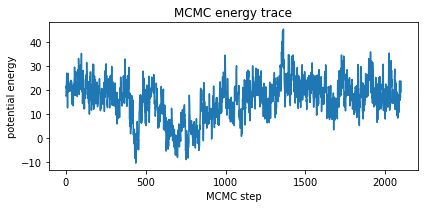

Warmup:   0%|          | 0/2100 [14:38, ?it/s]


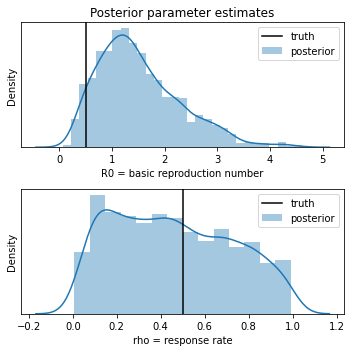

In [26]:
pyro.enable_validation(__debug__)
pyro.set_rng_seed(args.rng_seed)


dataset = generate_data(args)
obs = dataset["obs"][:args.duration]
# Choose among inference methods.
if args.enum:
    samples = infer_hmc_enum(args, obs)
elif args.sequential:
    samples = infer_hmc_cont(continuous_model, args, obs)
else:
    samples = infer_hmc_cont(vectorized_model, args, obs)

# Evaluate fit.
evaluate(args, samples)

# Predict latent time series.
if args.forecast:
    samples = predict(args, obs, samples, truth=dataset["S2I"])

    


In [19]:
dataset = generate_data(args)
obs = dataset["obs"][:args.duration]


Generating data...
Observed 3/7 infections:
3


In [42]:
dataset

{'S2I': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 2., 0., 1., 0., 0., 0., 1.]),
 'obs': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.]),
 'I2R': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])}

In [20]:
obs

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.])

Forecasting 0 steps ahead...
Median prediction of new infections (starting on day 0):
0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1


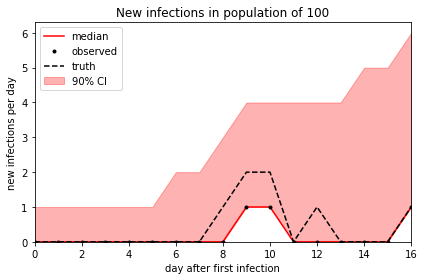

In [41]:
samples = predict(args, obs, samples, truth=dataset["S2I"])

